In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [6]:
MAX_SENT_LENGTH = 50
MAX_SENTS = 30
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [7]:
cd '/content/drive/My Drive/Dataset'

/content/drive/My Drive/Dataset


In [8]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os
import sys
import pickle
import itertools
import gensim
from sklearn.model_selection import train_test_split
from numpy import zeros
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec

In [9]:
reviews_df = pd.read_csv('Hotel_Review.csv')
print(reviews_df.dtypes)
reviews_df = reviews_df.dropna()
reviews_df = reviews_df.reset_index(drop=True)
print('Shape of dataset ',reviews_df.shape)
print(reviews_df.columns)

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
dtype: object
Shape of dataset  (512470, 17)
Index(['Hotel_Address', 'Additional_N

In [10]:
def clean(text):
    '''
    '''
    text = text.lower()
    text = text.replace("ain't", "am not")
    text = text.replace("aren't", "are not")
    text = text.replace("can't", "cannot")
    text = text.replace("can't've", "cannot have")
    text = text.replace("'cause", "because")
    text = text.replace("could've", "could have")
    text = text.replace("couldn't", "could not")
    text = text.replace("couldn't've", "could not have")
    text = text.replace("should've", "should have")
    text = text.replace("should't", "should not")
    text = text.replace("should't've", "should not have")
    text = text.replace("would've", "would have")
    text = text.replace("would't", "would not")
    text = text.replace("would't've", "would not have")
    text = text.replace("didn't", "did not")
    text = text.replace("doesn't", "does not")
    text = text.replace("don't", "do not")
    text = text.replace("hadn't", "had not")
    text = text.replace("hadn't've", "had not have")
    text = text.replace("hasn't", "has not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd", "he would")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd've", "he would have")
    text = text.replace("'s", "")
    text = text.replace("'t", "")
    text = text.replace("'ve", "")
    text = text.replace(".", " . ")
    text = text.replace("!", " ! ")
    text = text.replace("?", " ? ")
    text = text.replace(";", " ; ")
    text = text.replace(":", " : ")
    text = text.replace(",", " , ")
    text = text.replace("´", "")
    text = text.replace("‘", "")
    text = text.replace("’", "")
    text = text.replace("“", "")
    text = text.replace("”", "")
    text = text.replace("\'", "")
    text = text.replace("\"", "")
    text = text.replace("-", "")
    text = text.replace("–", "")
    text = text.replace("—", "")
    text = text.replace("[", "")
    text = text.replace("]","")
    text = text.replace("{","")
    text = text.replace("}", "")
    text = text.replace("/", "")
    text = text.replace("|", "")
    text = text.replace("(", "")
    text = text.replace(")", "")
    text = text.replace("$", "")
    text = text.replace("+", "")
    text = text.replace("*", "")
    text = text.replace("%", "")
    text = text.replace("#", "")
    text = text.replace("\n", " \n ")
    text = text.replace("\n", "")
    text = text.replace("_", " _ ")
    text = text.replace("_", "")
    text = ''.join([i for i in text if not i.isdigit()])

    return text

positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values

cleaned_positive_reviews = [clean(r) for r in positive_reviews]
cleaned_negative_reviews = [clean(r) for r in negative_reviews]

reviews_df['Positive_Review'] = cleaned_positive_reviews
reviews_df['Negative_Review'] = cleaned_negative_reviews

In [11]:
# Shuffling data
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)

# Extracting all text
positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values
reviews_text = []

for p,n in zip(positive_reviews, negative_reviews) :
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        reviews_text.append(n)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        reviews_text.append(p)
    else :
        reviews_text.append(n)
        reviews_text.append(p)

In [12]:
# Preprocessing training data
training_df = reviews_df.loc[:10000]
positive_reviews_filtered = training_df['Positive_Review'].values
negative_reviews_filtered = training_df['Negative_Review'].values
training_reviews = []
labels = []

for idx,(p,n) in enumerate(zip(positive_reviews_filtered, negative_reviews_filtered)) :
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        training_reviews.append(n)
        labels.append(0)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        training_reviews.append(p)
        labels.append(1)
    else :
        training_reviews.append(n)
        labels.append(0)
        training_reviews.append(p)
        labels.append(1)

# Creating datasets
dict1 ={
    'reviews' : training_reviews,
    'labels' : labels
}
sentiment_df = pd.DataFrame.from_dict(dict1)


dict2 ={
    'reviews_text' : reviews_text
}
reviews_text_df = pd.DataFrame.from_dict(dict2)

In [13]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.layers import Layer, InputSpec
from keras import initializers
%matplotlib inline

In [14]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [15]:
MAX_SENT_LENGTH = 50
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [16]:
sentiment_df = sentiment_df.dropna()
sentiment_df = sentiment_df.reset_index(drop=True)
print('Shape of dataset ',sentiment_df.shape)
print(sentiment_df.columns)
print('No. of unique classes',len(set(sentiment_df['labels'])))

Shape of dataset  (16892, 2)
Index(['reviews', 'labels'], dtype='object')
No. of unique classes 2


In [17]:
import nltk
from nltk import tokenize

reviews = []
labels = []
texts = []

In [18]:
macronum=sorted(set(sentiment_df['labels']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

In [19]:
def fun(i):
    return macro_to_id[i]

sentiment_df['labels']=sentiment_df['labels'].apply(fun)

In [20]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
for i in range(sentiment_df.reviews.shape[0]):
    text = BeautifulSoup(sentiment_df.reviews[i])
    text=clean_str(str(text.get_text().encode()).lower())
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)


for i in sentiment_df['labels']:
    labels.append(i)

In [22]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1

In [23]:
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 12104 unique tokens.


In [24]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
#labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

Shape of data tensor: (16892, 15, 50)
Shape of label tensor: (16892, 2)


In [25]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [26]:
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [29]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            trainable=True)



In [30]:
import tensorflow as tf

In [31]:
model = tf.keras.Sequential([
    embedding_layer,
    # Add more layers here as needed
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1210500   
                                                                 
 dense (Dense)               (None, None, 64)          6464      
                                                                 
 dense_1 (Dense)             (None, None, 1)           65        
                                                                 
Total params: 1217029 (4.64 MB)
Trainable params: 1217029 (4.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Concatenate


In [33]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(50))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(50))(review_encoder)
preds = Dense(len(macronum), activation='softmax')(l_lstm_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Hierachical LSTM")
model.summary()

Hierachical LSTM
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 50)]          0         
                                                                 
 time_distributed (TimeDist  (None, 15, 100)           1270900   
 ributed)                                                        
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1331502 (5.08 MB)
Trainable params: 1331502 (5.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
cp=ModelCheckpoint('model_han_.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=5, batch_size=1028,callbacks=[cp])

Epoch 1/5
14/14 [==============================] - ETA: 0s - loss: 0.6890 - acc: 0.5484 
Epoch 1: val_acc improved from -inf to 0.54855, saving model to model_han_.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 199s 13s/step - loss: 0.6890 - acc: 0.5484 - val_loss: 0.6913 - val_acc: 0.5485
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 0.6888 - acc: 0.5484 
Epoch 2: val_acc did not improve from 0.54855
14/14 [==============================] - 171s 12s/step - loss: 0.6888 - acc: 0.5484 - val_loss: 0.6885 - val_acc: 0.5485
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 0.6888 - acc: 0.5484 
Epoch 3: val_acc did not improve from 0.54855
14/14 [==============================] - 168s 12s/step - loss: 0.6888 - acc: 0.5484 - val_loss: 0.6887 - val_acc: 0.5485
Epoch 4/5
14/14 [==============================] - ETA: 0s - loss: 0.6886 - acc: 0.5484 
Epoch 4: val_acc did not improve from 0.54855
14/14 [==============================] - 168s 12s/step - loss: 0.6886 - acc: 0.5484 - val_loss: 0.6885 - val_acc: 0.5485
Epoch 5/5
14/14 [==============================] - ETA: 0s - loss: 0.6885 - acc: 0.5484 
Epoch 5: val_acc did n

In [35]:
import keras

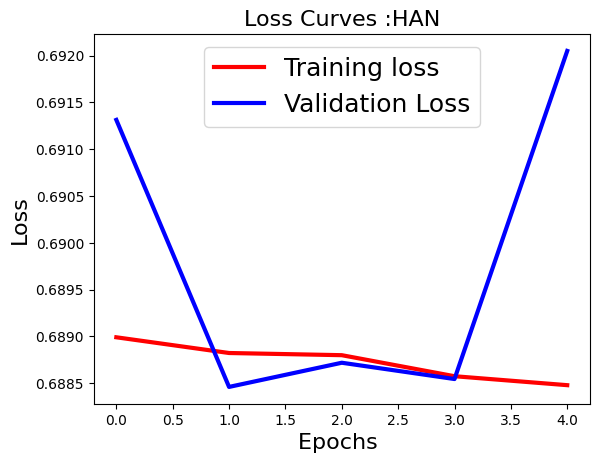

In [36]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :HAN',fontsize=16)
fig1.savefig('loss_han.png')
plt.show()

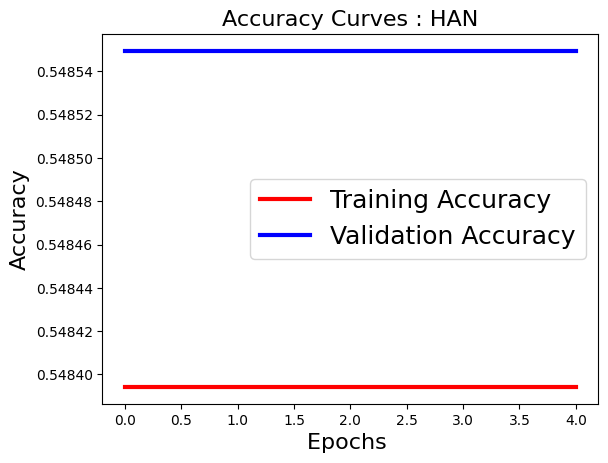

In [37]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig2.savefig('accuracy_han.png')
plt.show()

In [38]:
loss, accuracy = model.evaluate(x_val,y_val)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))

106/106 [==============================] - 16s 152ms/step - loss: 0.6921 - acc: 0.5485
Test Loss: 0.6920501589775085
Test Accuracy: 0.5485494136810303


In [39]:
from sklearn import preprocessing

In [44]:
# Make predictions using your model
model_predictions = model.predict(x_val)

# Make sure the predictions are converted to binary labels
binary_predictions = (model_predictions > 0.5).astype('int32')


106/106 [==============================] - 21s 156ms/step


In [45]:
from sklearn.metrics import hamming_loss

# Calculate Hamming loss
hamming_loss_value = hamming_loss(y_val, binary_predictions)
print("Hamming Loss:", hamming_loss_value)


Hamming Loss: 0.45145056246299586


In [46]:
from sklearn.metrics import accuracy_score

# Calculate subset accuracy
subset_accuracy = accuracy_score(y_val, binary_predictions)
print("Subset Accuracy:", subset_accuracy)


Subset Accuracy: 0.5485494375370041


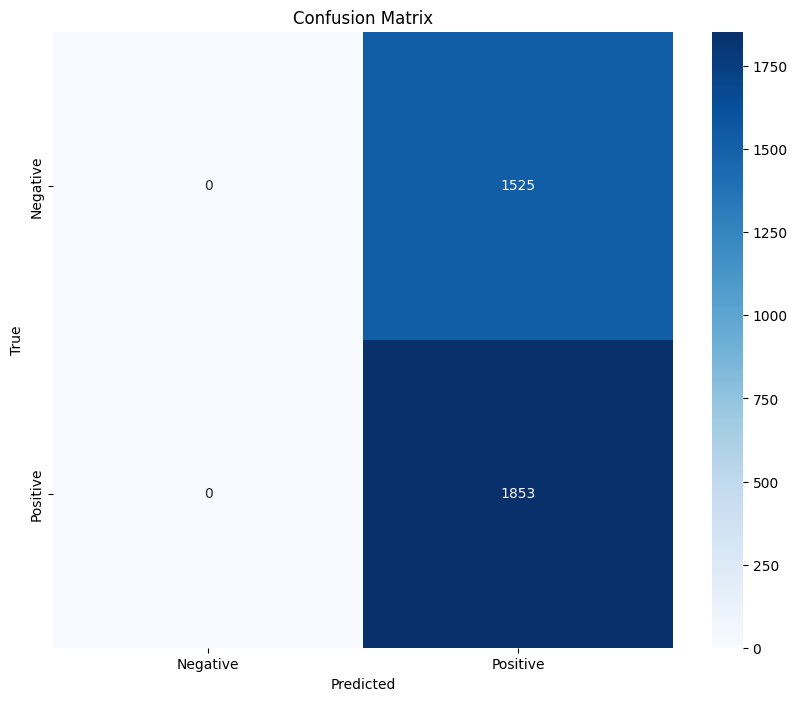

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_val.argmax(axis=1), binary_predictions.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


106/106 [==============================] - 18s 174ms/step
Average Matthews Correlation Coefficient: 0.0
Average ROC AUC: 0.503414843452797


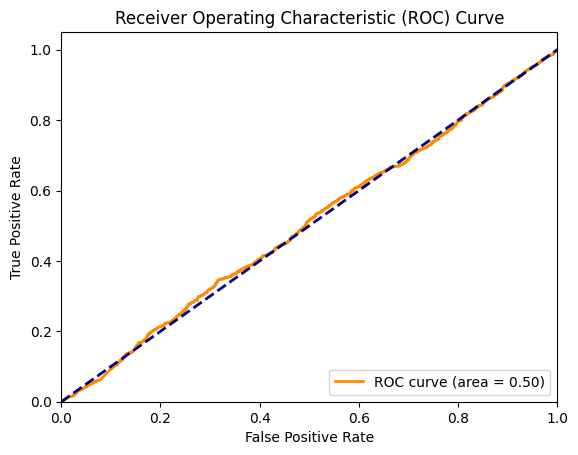

Average Precision-Recall AUC: 0.49861877897488055


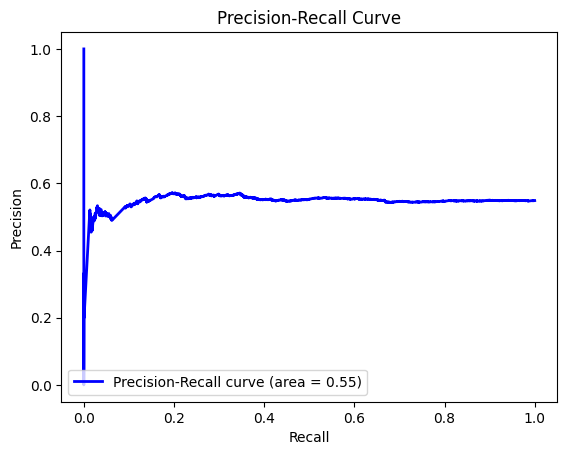

In [48]:
from sklearn.metrics import matthews_corrcoef, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Make predictions using your model
model_predictions = model.predict(x_val)

num_classes = y_val.shape[1]

# Make sure the predictions are converted to binary labels
binary_predictions = (model_predictions > 0.5).astype('int32')

# Calculate Matthews Correlation Coefficient (MCC) for each label
mcc_per_label = []
for i in range(num_classes):  # Assuming num_classes is the number of classes
    mcc_label = matthews_corrcoef(y_val[:, i], binary_predictions[:, i])
    mcc_per_label.append(mcc_label)

# Compute average MCC across all labels
mcc_average = np.mean(mcc_per_label)

print("Average Matthews Correlation Coefficient:", mcc_average)

# Compute ROC curve and ROC area for each label
roc_auc_per_label = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val[:, i], model_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_per_label.append(roc_auc)

# Compute average ROC AUC across all labels
roc_auc_average = np.mean(roc_auc_per_label)

print("Average ROC AUC:", roc_auc_average)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute precision-recall curve and area under the curve for each label
pr_auc_per_label = []
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_val[:, i], model_predictions[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_per_label.append(pr_auc)

# Compute average precision-recall AUC across all labels
pr_auc_average = np.mean(pr_auc_per_label)

print("Average Precision-Recall AUC:", pr_auc_average)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [49]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_val, binary_predictions)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1525
           1       0.55      1.00      0.71      1853

   micro avg       0.55      0.55      0.55      3378
   macro avg       0.27      0.50      0.35      3378
weighted avg       0.30      0.55      0.39      3378
 samples avg       0.55      0.55      0.55      3378



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:
# Get the weights of the first layer if available, otherwise provide an empty list
layer_weights = model.layers[0].get_weights() if model.layers and model.layers[0].get_weights() else []

# Calculate the absolute sum of weights for each feature if weights exist, otherwise set feature importance to 0
feature_importance = np.sum(np.abs(layer_weights[0])) if layer_weights else 0

# Print the feature importance value
print("Feature Importance:", feature_importance)


Feature Importance: 0


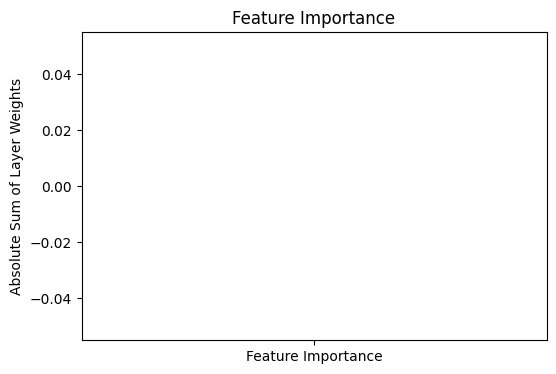

Feature Importance: 0


In [74]:
# Plotting feature importance
plt.figure(figsize=(6, 4))
plt.bar(["Feature Importance"], [feature_importance])
plt.ylabel('Absolute Sum of Layer Weights')
plt.title('Feature Importance')
plt.show()
# Print the feature importance value
print("Feature Importance:", feature_importance)